In [218]:
using Interact
using GeometryTypes
using FixedSizeArrays
using LCMGL
using AffineTransforms
using SpatialFields
using ForwardDiff
using PyPlot

In [6]:
import DrakeVisualizer

In [231]:
include("arms.jl")

Arms

In [232]:
include("depth_sensors.jl")

DepthSensors

In [233]:
# Construct the manipulator and visualizer
arm = Arms.two_link_arm();
vis = DrakeVisualizer.Visualizer()
model = DrakeVisualizer.load(vis, arm);

In [266]:
# Construct the sensor and draw its view rays for debugging
sensor = DepthSensors.Kinect(100,100);
camera_origin = tformtranslate([0;0;4]) * tformrotate([pi;0;0])
LCMGLClient("sensor_rays") do lcmgl
    color(lcmgl, 0, 1, 0)
    begin_mode(lcmgl, LCMGL.LINES)
    for ray in sensor.rays
        vertex(lcmgl, camera_origin.offset...)
        vertex(lcmgl, (camera_origin.offset + camera_origin.scalefwd * convert(Vector, ray))...)
    end
    end_mode(lcmgl)
    switch_buffer(lcmgl)
end

In [305]:
# A helper function that takes the two arm angles, computes the implicit 
# surface, performs a raycast, and draws the result. 
function raycast_arm(x1, x2)
    origins = Arms.link_origins(arm, [x1; x2])
    DrakeVisualizer.draw(model, origins)
    skin = Arms.skin(arm, [x1; x2])
    DrakeVisualizer.load(vis, DrakeVisualizer.GeometryData(convert(GeometryTypes.HomogenousMesh, skin)), 2)
    
    points = DepthSensors.raycast_points(skin, sensor, camera_origin)
    LCMGLClient("raycast") do lcmgl
        color(lcmgl, 0, 1, 0)
        point_size(lcmgl, 5)
        begin_mode(lcmgl, LCMGL.POINTS)
        for point in points
            vertex(lcmgl, convert(Vector, point)...)
        end
        end_mode(lcmgl)
        switch_buffer(lcmgl)
    end
    points
end

raycast_arm (generic function with 1 method)

In [306]:
@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    points = raycast_arm(x1, x2)
end;

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x1",0.0,linspace(-3.141592653589793,3.141592653589793,101),true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x2",0.0,linspace(-3.141592653589793,3.141592653589793,101),true)

In [269]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [ ]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
x_true = [-1; 1.3]

# Now we can raycast that true state to get a set of sensed points:
sensed_points = raycast_arm(x_true...)

# Our cost function takes the two joint angles and returns the 
# squared sum of the value of the implicit surface at those sensed
# points. If we've recovered the true joint state, then that sum
# should be nearly zero. 
function cost(x)
    skin = Arms.skin(arm, x)
    return sum(point -> evaluate(skin, point)^2, sensed_points)
end

# Use autodiff to prepare a function that will evaluate the gradient
# of that cost:
g_cost = ForwardDiff.gradient(cost)

trials = []

for i = 1:100
    errors = []
    xs = []
    
    # We'll initialize our estimate with a uniformly random pair
    # of joint angles
    x_estimated = rand(2) * 2*pi - pi

    # Now we use gradient descent to recover the joint angles
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, x_true)))
        
        # Evaluate the gradient of the point values w.r.t. the
        # joint angles:
        gi = g_cost(x_estimated)
        
        if any(isnan, gi)
            @show x_estimated
            error("NaN in gradient")
        end
        
        # Descend the gradient
        x_estimated -= 0.0005 * gi
    end
    push!(trials, (xs, errors))
end


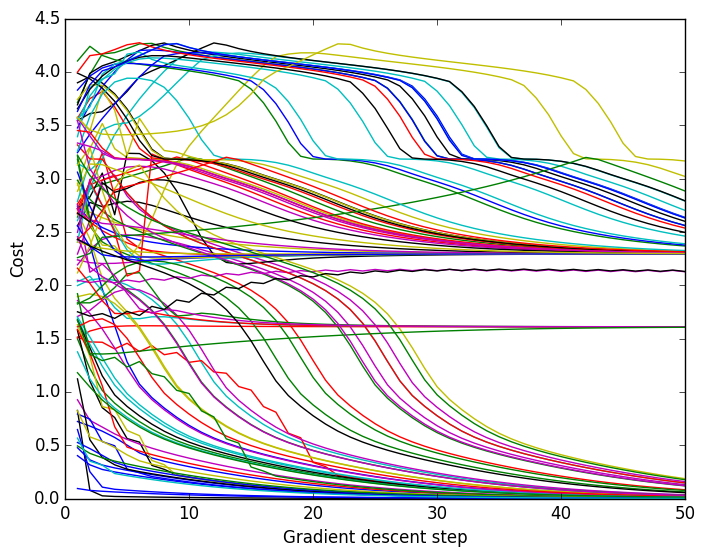

PyObject <matplotlib.text.Text object at 0x324242e90>

In [272]:
# Now we can plot the progress of each trial

figure()
hold(true)
for (xs, errors) in trials
    plot(1:length(errors), errors)
end
hold(false)
xlabel("Gradient descent step")
ylabel("Cost")

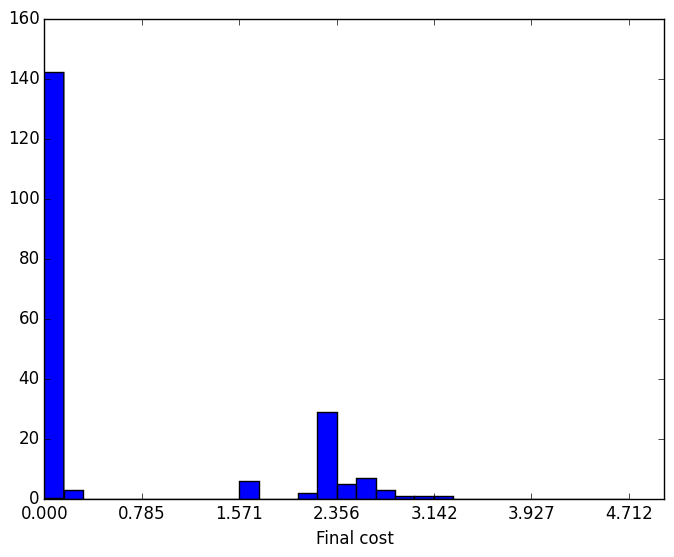

PyObject <matplotlib.text.Text object at 0x32488fb90>

In [304]:
# A histogram of the final cost of each trial shows that most random
# configurations eventually converged to the correct answer (a final
# cost near 0.0), but that some got stuck in local minima

PyPlot.plt[:hist]([errors[end] for (xs, errors) in trials], 0:pi/20:3*pi/2);
xticks(0:pi/4:3*pi/2);
xlabel("Final cost")

In [290]:
# Now let's repeat the trial, but starting within + or - 0.5 of the true
# joint angles (to simulate running online with a good initial guess).

x_true = [-1; 1.3]

sensed_points = raycast_arm(x_true...)

function cost(x)
    skin = Arms.skin(arm, x)
    return sum(point -> evaluate(skin, point)^2, sensed_points)
end

trials_close = []

for i = 1:100
    errors = []
    xs = []
    
    # Start within +- 0.5 of x_true
    x_estimated = (rand(2) - 0.5) + x_true


    g_cost = ForwardDiff.gradient(cost)
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, x_true)))
        gi = g_cost(x_estimated)
        if any(isnan, gi)
            @show x_estimated
            error("NaN in gradient")
        end
        x_estimated -= 0.0005 * gi
    end
    push!(trials_close, (xs, errors))
end

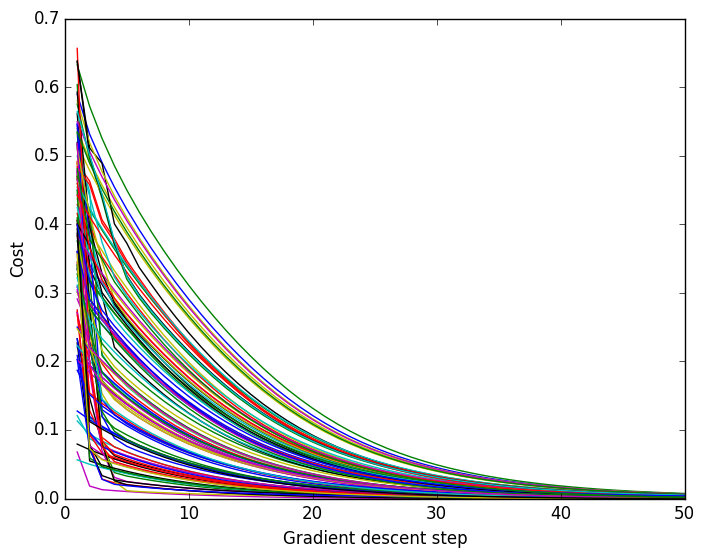

PyObject <matplotlib.text.Text object at 0x31ffb4ad0>

In [292]:
# And again, let's plot each trial's progress:

figure()
hold(true)
for (xs, errors) in trials_close
    plot(1:length(errors), errors)
end
hold(false)
xlabel("Gradient descent step")
ylabel("Cost")

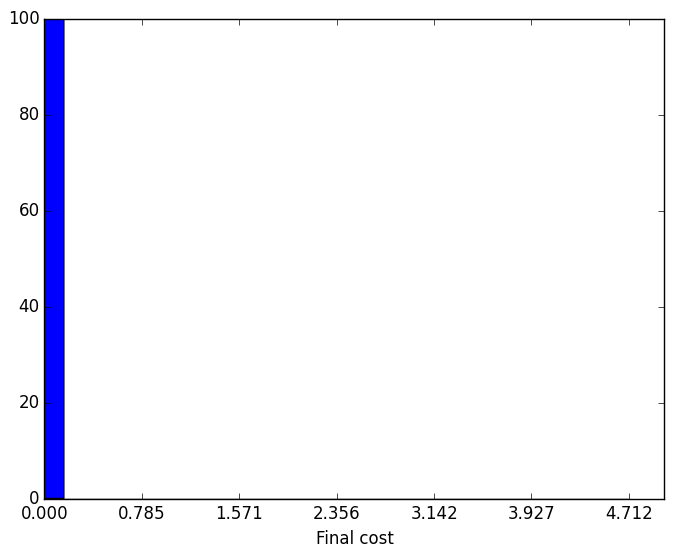

PyObject <matplotlib.text.Text object at 0x326e51c50>

In [302]:
# When starting out reasonably close to the correct configuration, every
# single sample converged to the true joint angles. The histogram confirms:

PyPlot.plt[:hist]([errors[end] for (xs, errors) in trials_close], 0:pi/20:3*pi/2);
xticks(0:pi/4:3*pi/2);
xlabel("Final cost")